# Exploratory Graphoid Analysis

> Toward Principled Graphical Model Recovery

## Modeling Edges...as Data?

In [217]:
import networkx as nx
import pandas as pd
from scipy import sparse, linalg
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [218]:
rng = np.random.default_rng(seed=2)

First, let's model a common "social network analysis" task: co-citation networks. 

1. What is our **goal**? 
    > we want to see how authors are "connected" to each other, based on how they write together. 
2. How does our data get created? 
    > Based on how "connected" authors are, they will be more likely to write papers together. Let's say a friendship _causes_ one author to have a higher probability of co-authoring a given paper, if their friend is an author. 
    >
    >We directly observe the resulting indicators (authors co-authored a given paper, for each paper in our dataset). 
3. How is our goal related to our data?
    > Note that we now have an _inverse problem_: what set of friendships would lead to a set of authorships that we observe?  

### Synthesize the Data    

Let's directly create a "relaistic" friendship graph.
A reasonable limitation is that people are either pairwise friends or part of a friend "group". 
In other words, if you start with 3 friends, and two of those friends know each other and they both a 4th person, you would also know that 4th person. 

> This is the set of single-vertex-separator graphs, block-graphs, or "clique" unions. 

It happens we can exactly represent the set of block graphs as the line graphs of trees. 
> Both of these classes of graphs are important for the Hammersly-Clifford Theorem, which will become critical, later. 

In [235]:
n_authors=20
author_idx = pd.CategoricalIndex((f'author_{i}' for i in range(1,n_authors+1)))

friendships = nx.random_tree(n_authors+1, seed=2) # real events... what "happens" as evidence of a relationship
author_rel = nx.relabel.relabel_nodes(nx.convert_node_labels_to_integers(nx.line_graph(friendships)),dict(zip(range(n_authors),author_idx.categories.tolist())))  # inferred structure
# author_rel.

Text(0.5, 1.0, 'Author Friendships')

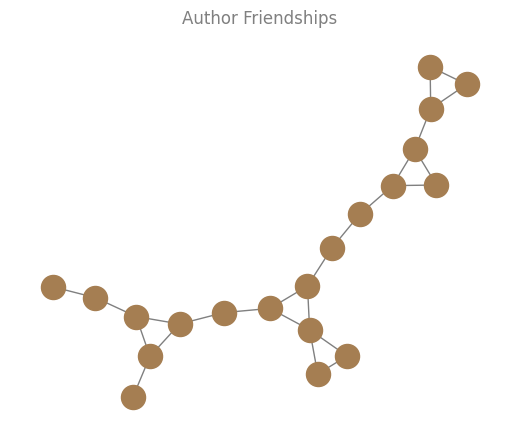

In [240]:
f = plt.figure(figsize=(5,4)).patch.set_alpha(0.)
nx.draw(author_rel, pos=nx.layout.kamada_kawai_layout(author_rel), 
        node_color='xkcd:puce', edge_color='grey')
plt.title('Author Friendships', color='grey')

### What have we observed? 

This is an Incidence Structure, where a friendship is a set (of cardinality 2), and an author is a line. 
Note that the incidence representation of the data is a matrix where the features are 'nodes' and the observations are 'edges'. 

In [241]:
# nx.incidence_matrix(author_rel)
incidence = (
    pd.Series.sparse.from_coo(nx.incidence_matrix(author_rel, oriented=True).tocoo())#.set_index(author_idxlevel=0)%%!
    .pipe(lambda df: df.set_axis(df.index.set_levels(author_idx, level=0).swaplevel()))
    .sort_index()
    .astype('Sparse[int]')
)
incidence.head()
# sparse.csc_array.to

0  author_1   -1
   author_8    1
1  author_1   -1
   author_7    1
2  author_2   -1
dtype: Sparse[int64, 0]

In [242]:
B = incidence.unstack().fillna(0.)
B.head()

,author_1,author_10,author_11,author_12,author_13,author_14,author_15,author_16,author_17,author_18,author_19,author_2,author_20,author_3,author_4,author_5,author_6,author_7,author_8,author_9
0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0


This is different from the adjacency representation, where the sparse representation comes from an "edgelist" view:

In [135]:
edgelist = (
    nx.to_pandas_edgelist(author_rel)
 # .astype(dict(source=author_idx, target=author_idx))
    .assign(
        source=lambda df: pd.Categorical.from_codes(df.source, dtype=author_idx.dtype),
        target=lambda df: pd.Categorical.from_codes(df.target, dtype=author_idx.dtype)
    )
)
edgelist.head()

,source,target
0,author_1,author_16
1,author_1,author_15
2,author_10,author_11
3,author_10,author_3
4,author_11,author_3


However, the two are _related_. 

The Laplacian is defined as the grammian of the _oriented_ incidence matrix: 

<AxesSubplot: >

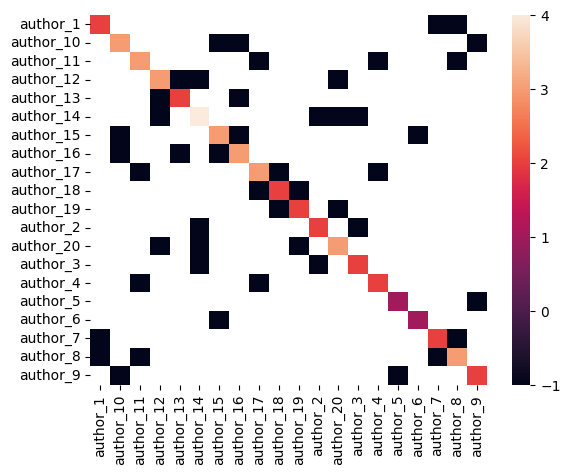

In [243]:
L = B.T@B
# L = incidence.sparse.to_coo()[0].T@incidence.sparse.to_coo()[0]
sns.heatmap(L, mask=L==0)

### Hang on, the Grammian? That sounds familiar...

Indeed, from an edge-observational point of vieew, the Laplacian would just be the unscaled scatter matrix of our sample data: 

$$S = \frac{1}{N-1} X^TX = \frac{1}{N-1}L$$

In turn, our data covariance would be the _centered_ version of our data. 
> NOTE that for _undirected graphs_, we are implicitly observing two copies of each "oriented edge" (one for each direction). So, we can easily show that the centered data matrix
> $$B_c = \begin{bmatrix} B \\-B\end{bmatrix}$$
> should have exactly $L_c = 2 L = (N-1)\frac{1}{2}S$

Thus undirected Laplacians are the unscaled covariance matrices of our edge observations, and we can be on our merry way using graphs and their laplacians to analyze our social network...right? 


### Some problems: what's in an edge? 

The Laplacian is typically used as a continuous-time analog for dynamic systems. 
For instance, it's the discrete _Laplace Operator_, a green's function for discrete Poisson equation: 
$$\frac{d x}{d t} = -kLx$$

It's also called the _Kirchoff Matrix_, due to its relation with the flow of current in an electrical network. It encodes the flow of energy from each node to the nodes it is connected to. 
> This explains the "oriented" part! Every edge means a unit of energy can flow "from" one node "to" another, according to the conductance between them!

But.... This has some major implications for our original model. Remember: 
> we want to connect authors if they have a friendship that corresponds to increased conditional probability of co-authorship. 

Nothing is "flowing". Our observation of authorship doesn't take away some amount of authorship from their friend at some subsequent timestep. 

> These kinds of issues are _everywhere_ in network analysis... ask yourself: **what do our edges measure?**

Instead of a friendship implying _negative correlation_ (see the negatives in all off-diagonals in $L$?), we probably want our friendships to indicate positive correlations. 

Do this by using the unsigned laplacian $L_S$, which we can get from the _unoriented_ incidence matrix. 

<AxesSubplot: >

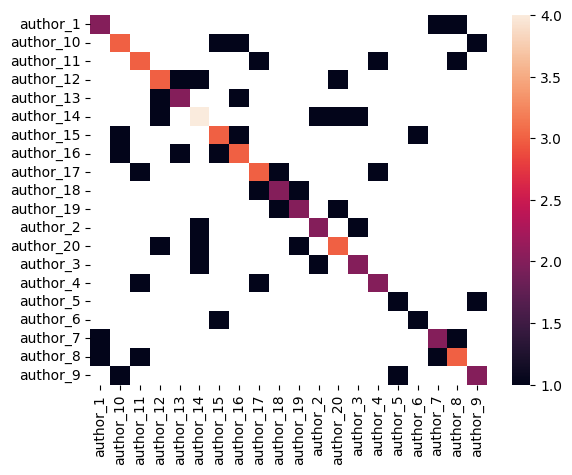

In [248]:
Ls = np.abs(B).T@np.abs(B)  # signless Laplacian
sns.heatmap(Ls, mask=Ls==0)
# sns.heatmap(np.linalg.inv(Ls), mask=np.abs(np.linalg.inv(Ls))<=0.1)
# sns.heatmap(np.linalg.pinv(2*L/(B.shape[0]-1)))
# sns.heatmap(np.linalg.inv(np.eye(n_authors)+0.05*L).dot(L))

Better, but recall that for our statistical modeling desires, empirical covariance must be centered (which only _happend_ to work out for us in the _oriented_ case. 

What does our graphical scatter look like now? 

<AxesSubplot: >

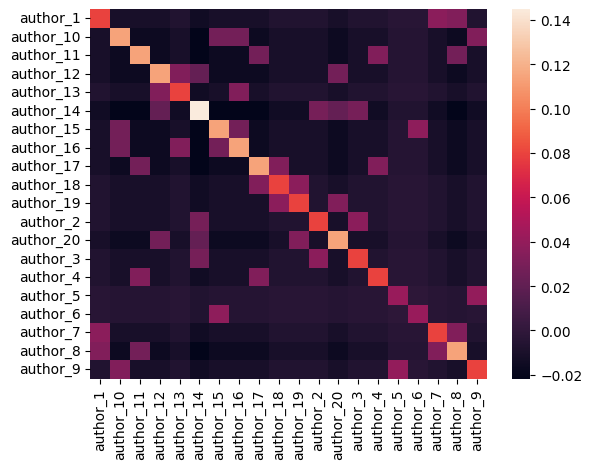

In [275]:
M = np.abs(B).cov()
sns.heatmap(M, mask=M==0)

Something is weird. 

There are negative values? 
Folks that weren't friends are now friends, and folks that didnt know each other at all... kinda oppose each other? 

> If you're not with me... _you're my enemy_. 

(Thanks a lot, ~~Anakin~~Darth Vader)

Indeed, the sample covariance matrix is a _biased_ intrinsic estimator. 
Estimating the true covariance from data is the problem of _Covariance Estimation_, which usually involves sparsity constraints and optimization of the determinant (Graphical Lasso). 

This is all _before we've even gotten to our actual observational model_, which will further obscure what exactly should and should not be real edges. 

Remember, what we want to _recover_ is a graph like the one at the top, where we see "real" friendships. even if our data is a set of observations of _only friends, exclusively, co-authoring a single paper per mutual friendship_, we would still be way off in determining friendships due to the bias inherent in the signless laplacian, and the normal laplacian is not at all going to model what we are after in the first place. 

> We need to recover the true covariance struture with better techniques than the co-occurrence laplacian, even if our data is _perfect_. 

And, trust me, it most certainly is _not_. 

## Modeling Observation Data as...Edges?

Let's use our gaussian probabilistic graphical model (it's a Markov Random Field) to generate some fake data. 
For each week in the next, say, 4 or so years, let's ask our set of vaugely-associated authors whether the wrote a paper or not. 

In [280]:
papers = pd.DataFrame(
    np.where(rng.multivariate_normal(np.zeros(n_authors), M, size=200)>0.3, 1,0),
    columns=author_idx
).rename_axis('week')
papers.melt(ignore_index=False).replace(0,np.nan).dropna()

,variable,value
week,,
1,author_1,1.0
18,author_1,1.0
24,author_1,1.0
30,author_1,1.0
34,author_1,1.0
...,...,...
173,author_20,1.0
182,author_20,1.0
187,author_20,1.0


<AxesSubplot: >

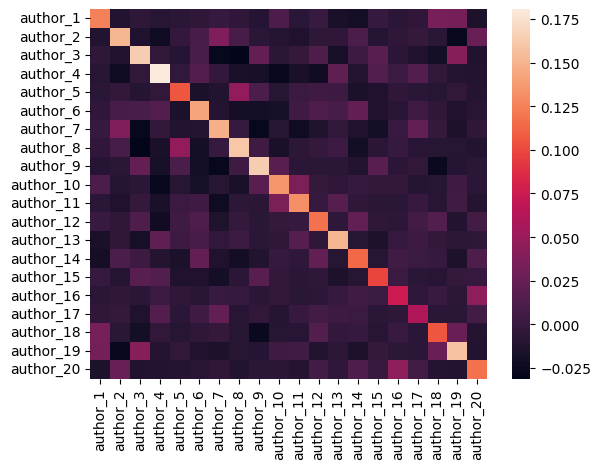

In [283]:
sns.heatmap(papers.cov())

Ok, what's going on...??

### TODO
Stop here...

<AxesSubplot: >

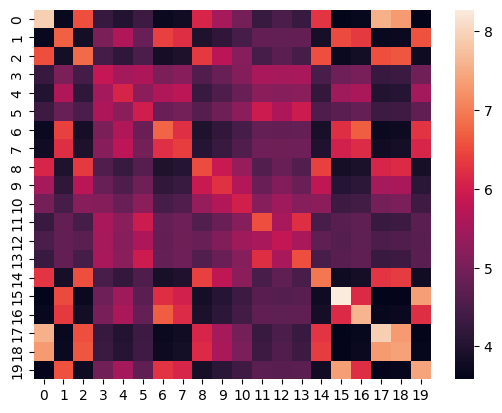

In [165]:
eps=0.01*np.eye(n_authors)

# sns.heatmap(sparse.linalg.inv(sparse.csc_array(L+eps)).todense())

In [176]:

# Create sparse, symmetric PSD matrix S
A = rng.standard_normal(size=(n_authors, n_authors))  # Unit normal gaussian distribution.
A[sparse.rand(n_authors, n_authors, 0.85).todense().nonzero()] = 0  # Sparsen the matrix.
Strue = A.dot(A.T) + 0.05 * np.eye(n_authors)  # Force strict pos. def.

# Create the covariance matrix associated with S.
R = np.linalg.inv(Strue)

# Create samples y_i from the distribution with covariance R.
y_sample = linalg.sqrtm(R).dot(rng.standard_normal((n_authors, 30)))

# Calculate the sample covariance matrix.
Y = np.cov(y_sample)

<AxesSubplot: >

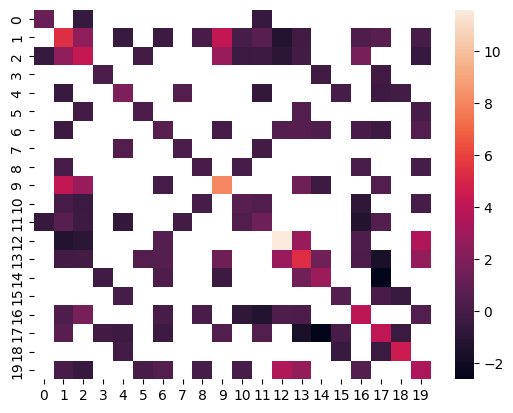

In [183]:
sns.heatmap(Strue, mask=Strue==0)

<AxesSubplot: >

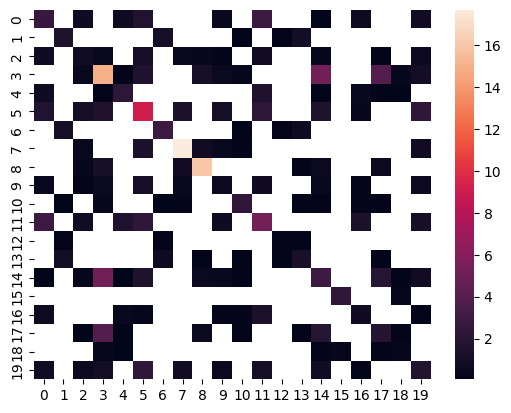

In [192]:
sns.heatmap(R, mask=R<=0.05)

<AxesSubplot: >

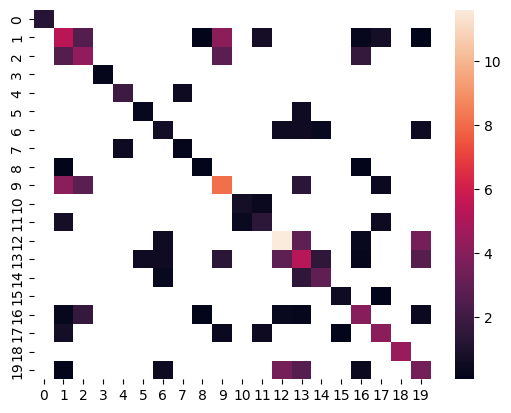

In [200]:
sns.heatmap(np.linalg.inv(R), mask=np.linalg.inv(R)<=0.05)